# BupaR Pattern Mining Analysis: Cohort 6: Age 65-74
[Return to Main Pipeline](../pgx_cohort_pipeline.ipynb)

In [1]:
quiet <- function(expr) {
  suppressMessages(suppressWarnings(eval(expr)))
}

## 1. Prescription Drug Itemsets

In [2]:
quiet({

    library(duckdb)
    library(arrow)
    library(dplyr)
    library(bupaR)
    library(bupaverse)
    library(lubridate)
    
    
    # Setup DuckDB and S3 access
    con <- dbConnect(duckdb::duckdb(), dbdir = ":memory:")
    dbExecute(con, "INSTALL httpfs; LOAD httpfs;")
    dbExecute(con, "INSTALL aws; LOAD aws;")
    dbExecute(con, "CALL load_aws_credentials();")
    
    
    query <- "
      SELECT * 
      FROM read_parquet(
        's3://pgxdatalake/itemsets_parquet/cohort_name=ed_non_opioid/age_band=65-74/event_year=*/itemsets.parquet'
      )
    "
    
    itemsets_df <- dbGetQuery(con, query)
    
    itemsets_df <- itemsets_df %>%
      select(-"__index_level_0__")
    
    itemsets_df %>%
      str()
})

'data.frame':	63 obs. of  5 variables:
 $ support    : num  0.152 0.1423 0.1126 0.0851 0.084 ...
 $ itemsets   : chr  "drug_amlodipine_besylate" "drug_atorvastatin_calcium" "drug_lisinopril" "drug_hydrochlorothiazide" ...
 $ age_band   : chr  "65-74" "65-74" "65-74" "65-74" ...
 $ cohort_name: chr  "ed_non_opioid" "ed_non_opioid" "ed_non_opioid" "ed_non_opioid" ...
 $ event_year : num  2016 2016 2016 2016 2016 ...


NULL

In [3]:
frequent_drugs <- itemsets_df %>%
  pull(itemsets) %>%
  gsub("^drug_", "", .) %>%
  unique() %>%
  sort()

frequent_drugs

[1] "ac_hydrocodone_bitartrate"                    
 [2] "albuterol"                                    
 [3] "amlodipine_besylate"                          
 [4] "amlodipine_besylate|drug_atorvastatin_calcium"
 [5] "amoxicillin"                                  
 [6] "atorvastatin_calcium"                         
 [7] "azithromycin"                                 
 [8] "fluticasone_propionate"                       
 [9] "furosemide"                                   
[10] "gabapentin"                                   
[11] "hydrochlorothiazide"                          
[12] "levothyroxine_sodium"                         
[13] "lisinopril"                                   
[14] "losartan_potassium"                           
[15] "metformin"                                    
[16] "metoprolol"                                   
[17] "omeprazole"                                   
[18] "pravastatin"                                  
[19] "prednisone"                                   
[20] "simvastatin"                                  
[21] "tramadol"

## 2. Event Log Datasets

#### Load Feature Engineered Data

In [4]:
query <- "
  SELECT * 
  FROM read_parquet(
    's3://pgxdatalake/fpgrowth_features_parquet/cohort_name=ed_non_opioid/age_band=65-74/event_year=*/fpgrowth_features.parquet'
  )
"

features_df <- dbGetQuery(con, query)


features_df %>%
  colnames()


[1] "mi_person_key"              "member_age_dos"            
  [3] "age_band"                   "member_zip_code_dos"       
  [5] "member_county_dos"          "member_age_band_dos"       
  [7] "member_gender"              "member_race"               
  [9] "event_date"                 "payer_type"                
 [11] "cchg_label"                 "cchg_grouping"             
 [13] "hcg_setting"                "hcg_line"                  
 [15] "hcg_detail"                 "place_of_service"          
 [17] "admit_type"                 "primary_icd_diagnosis_code"
 [19] "primary_icd_rollup"         "primary_icd_ccs_level_1"   
 [21] "primary_icd_ccs_level_2"    "primary_icd_ccs_level_3"   
 [23] "two_icd_diagnosis_code"     "two_icd_rollup"            
 [25] "three_icd_diagnosis_code"   "three_icd_rollup"          
 [27] "four_icd_diagnosis_code"    "four_icd_rollup"           
 [29] "five_icd_diagnosis_code"    "five_icd_rollup"           
 [31] "six_icd_diagnosis_code"     "six_icd_rollup"            
 [33] "seven_icd_diagnosis_code"   "seven_icd_rollup"          
 [35] "eight_icd_diagnosis_code"   "eight_icd_rollup"          
 [37] "nine_icd_diagnosis_code"    "nine_icd_rollup"           
 [39] "ten_icd_diagnosis_code"     "ten_icd_diagnosis_rollup"  
 [41] "procedure_code"             "procedure_name"            
 [43] "procedure_family_1"         "procedure_family_2"        
 [45] "procedure_family_3"         "two_icd_procedure_code"    
 [47] "three_icd_procedure_code"   "four_icd_procedure_code"   
 [49] "five_icd_procedure_code"    "six_icd_procedure_code"    
 [51] "seven_icd_procedure_code"   "eight_icd_procedure_code"  
 [53] "nine_icd_procedure_code"    "ten_icd_procedure_code"    
 [55] "cpt_mod_1_code"             "cpt_mod_2_code"            
 [57] "billing_provider_name"      "billing_provider_zip"      
 [59] "billing_provider_county"    "billing_provider_state"    
 [61] "service_provider_name"      "service_provider_zip"      
 [63] "service_provider_county"    "service_provider_state"    
 [65] "corrected_age"              "event_year"                
 [67] "event"                      "drug_name"                 
 [69] "therapeutic_class_1"        "therapeutic_class_2"       
 [71] "therapeutic_class_3"        "first_opioid_ed_date"      
 [73] "first_ed_non_opioid_date"   "first_medical_date"        
 [75] "first_pharmacy_date"        "first_event"               
 [77] "cohort_name"                "drug_tokens"               
 [79] "drug_encoding"              "encoded_drug_name"         
 [81] "pattern_1_enc_0"            "pattern_1_enc_1"           
 [83] "pattern_1_enc_2"            "pattern_1_enc_3"           
 [85] "pattern_1_enc_4"            "pattern_1_enc_5"           
 [87] "pattern_1_enc_6"            "pattern_2_enc_0"           
 [89] "pattern_2_enc_1"            "pattern_2_enc_2"           
 [91] "pattern_2_enc_3"            "pattern_2_enc_4"           
 [93] "pattern_2_enc_5"            "pattern_2_enc_6"           
 [95] "pattern_3_enc_0"            "pattern_3_enc_1"           
 [97] "pattern_3_enc_2"            "pattern_3_enc_3"           
 [99] "pattern_3_enc_4"            "pattern_3_enc_5"           
[101] "pattern_3_enc_6"            "pattern_4_enc_0"           
[103] "pattern_4_enc_1"            "pattern_4_enc_2"           
[105] "pattern_4_enc_3"            "pattern_4_enc_4"           
[107] "pattern_4_enc_5"            "pattern_4_enc_6"           
[109] "pattern_5_enc_0"            "pattern_5_enc_1"           
[111] "pattern_5_enc_2"            "pattern_5_enc_3"           
[113] "pattern_5_enc_4"            "pattern_5_enc_5"           
[115] "pattern_5_enc_6"            "pattern_6_enc_0"           
[117] "pattern_6_enc_1"            "pattern_6_enc_2"           
[119] "pattern_6_enc_3"            "pattern_6_enc_4"           
[121] "pattern_6_enc_5"            "pattern_6_enc_6"           
[123] "pattern_7_enc_0"            "pattern_7_enc_1"           
[125] "pattern_7_enc_2"           

In [5]:
pgx_df <- features_df %>%
  filter(sapply(drug_tokens, function(tokens) any(tokens %in% frequent_drugs)) | first_event == "ED_NON_OPIOID") %>%
  select(mi_person_key, member_age_dos, age_band, member_gender, member_race,
         event_date, event_year, drug_name,
         event) %>%
  mutate(target = if_else(event == "ED_NON_OPIOID", 1, 0))



print(str(pgx_df))

'data.frame':	824942 obs. of  10 variables:
 $ mi_person_key : chr  "1005220042" "1005220042" "1005220042" "1005220042" ...
 $ member_age_dos: chr  "68" "68" "68" "68" ...
 $ age_band      : chr  "65-74" "65-74" "65-74" "65-74" ...
 $ member_gender : chr  "M" "M" "M" "M" ...
 $ member_race   : chr  "05" "05" "05" "05" ...
 $ event_date    : POSIXct, format: "2016-01-08" "2016-01-08" ...
 $ event_year    : num  2016 2016 2016 2016 2016 ...
 $ drug_name     : chr  NA NA NA NA ...
 $ event         : chr  "Medical" "Medical" "Medical" "Medical" ...
 $ target        : num  0 0 0 0 0 0 0 0 0 0 ...
NULL


In [6]:
event_counts <- pgx_df %>%
  count(event, sort = TRUE)  # sort=TRUE gives you most frequent first

print(event_counts)


          event      n
1       Medical 553082
2      Pharmacy 206652
3 ED_NON_OPIOID  65208


In [10]:
# Step 1: Confirm original number of patients
cat("✓ Total distinct patients in pgx_df:", n_distinct(pgx_df$mi_person_key), "\n\n")

# Step 2: Collapse to one row per patient with first non-NA gender and race
demographics_df <- pgx_df %>%
  arrange(mi_person_key) %>%
  group_by(mi_person_key) %>%
  summarise(
    member_gender = first(na.omit(member_gender)),
    member_race   = first(na.omit(member_race)),
    .groups = "drop"
  )

# Step 3: Confirm final number of patients in collapsed demographic data
cat("✓ Distinct patients (after collapsing):", nrow(demographics_df), "\n\n")

# Step 4: Count patients by gender
cat("✓ member_gender (distinct patients):\n")
print(
  demographics_df %>%
    count(member_gender, name = "distinct_patients") %>%
    arrange(desc(distinct_patients))
)

# Step 5: Count patients by race
cat("\n✓ member_race (distinct patients):\n")
print(
  demographics_df %>%
    count(member_race, name = "distinct_patients") %>%
    arrange(desc(distinct_patients))
)


cat("\n✓ drug_name:\n")
print(
  head(sort(table(pgx_df$drug_name), decreasing = TRUE), 25)
)

cat("\n✓ target:\n")
print(table(pgx_df$target, useNA = "ifany"))

cat("\n✓ event:\n")
print(table(pgx_df$event, useNA = "ifany"))


✓ Total distinct patients in pgx_df: 4977 

✓ Distinct patients (after collapsing): 4977 

✓ member_gender (distinct patients):
# A tibble: 2 × 2
  member_gender distinct_patients
  <chr>                     <int>
1 F                          2815
2 M                          2162

✓ member_race (distinct patients):
# A tibble: 7 × 2
  member_race distinct_patients
  <chr>                   <int>
1 05                       2888
2 09                        999
3 03                        855
4 0N                        167
5 02                         66
6 01                          1
7 04                          1

✓ drug_name:

     atorvastatin_calcium       amlodipine_besylate                lisinopril 
                     6343                      4973                      4374 
               gabapentin      levothyroxine_sodium                furosemide 
                     4049                      3950                      3736 
               omeprazole                 met

### QA Checks

###  ADE Cohort

In [11]:
# Step 1: Clean drug names and handle missing values
pgx_df <- pgx_df %>%
  mutate(
    # Assign placeholder only if missing and target == 1
    drug_name = case_when(
      is.na(drug_name) & target == 1 ~ "placeholder",
      TRUE ~ drug_name
    )
  ) %>%
  # Drop NA drugs for control cohort (target == 0)
  filter(!(target == 0 & is.na(drug_name))) %>%
  # Drop short/informationally empty names
  filter(nchar(drug_name) > 1)

# Step 2: Get list of target==1 individuals
target_keys <- pgx_df %>%
  filter(target == 1) %>%
  distinct(mi_person_key)

# Step 3: Subset rows for those target==1 individuals
# and finalize drug names for event log
pgx_df_target1_with_drugs <- pgx_df %>%
  semi_join(target_keys, by = "mi_person_key") %>%
  # Replace placeholder with ADE_EVENT for clarity
  mutate(
    drug_name = if_else(drug_name == "placeholder", "ADE_EVENT", drug_name)
  ) %>%
  # Sanity filter to ensure valid entries
  filter(!is.na(drug_name), drug_name != "", drug_name != "NA")

# Count frequency of activities
pgx_df_target1_with_drugs %>%
  count(drug_name, sort = TRUE)


drug_name,n
<chr>,<int>
ADE_EVENT,65208
atorvastatin_calcium,6343
amlodipine_besylate,4973
lisinopril,4374
gabapentin,4049
levothyroxine_sodium,3950
furosemide,3736
omeprazole,3406
metformin,3077


In [12]:

# Create the event log
target_eventlog <- pgx_df_target1_with_drugs %>%
  transmute(
    case_id = mi_person_key,
    timestamp = as.POSIXct(event_date),
    activity = drug_name,
    lifecycle_id = "start"
  ) %>%
  arrange(case_id, timestamp) %>%
  mutate(
    activity_instance_id = row_number(),
    resource_id = "Patient"
  ) %>%
  eventlog(
    case_id = "case_id",
    activity_id = "activity",
    timestamp = "timestamp",
    lifecycle_id = "lifecycle_id",
    activity_instance_id = "activity_instance_id",
    resource_id = "resource_id"
  )


Number of events:  271860
Number of cases:  4977
Number of traces:  3574
Number of distinct activities:  1895
Average trace length:  54.62327

Start eventlog:  2016-01-01
End eventlog:  2020-12-31



   case_id            timestamp                        activity        
 Length:271860      Min.   :2016-01-01 00:00:00.00   Length:271860     
 Class :character   1st Qu.:2017-06-12 00:00:00.00   Class :character  
 Mode  :character   Median :2018-07-13 00:00:00.00   Mode  :character  
                    Mean   :2018-07-14 13:40:41.25                     
                    3rd Qu.:2019-08-28 00:00:00.00                     
                    Max.   :2020-12-31 00:00:00.00                     
 lifecycle_id       activity_instance_id resource_id            .order      
 Length:271860      Min.   :     1       Length:271860      Min.   :     1  
 Class :character   1st Qu.: 67966       Class :character   1st Qu.: 67966  
 Mode  :character   Median :135930       Mode  :character   Median :135930  
                    Mean   :135930                          Mean   :135930  
                    3rd Qu.:203895                          3rd Qu.:203895  
                    Max.   :271860

activity,absolute_frequency,relative_frequency
<chr>,<int>,<dbl>
ADE_EVENT,65208,0.239858751
atorvastatin_calcium,6343,0.023331862
amlodipine_besylate,4973,0.018292503
lisinopril,4374,0.016089164
gabapentin,4049,0.014893695
levothyroxine_sodium,3950,0.014529537
furosemide,3736,0.013742367
omeprazole,3406,0.012528507
metformin,3077,0.011318326


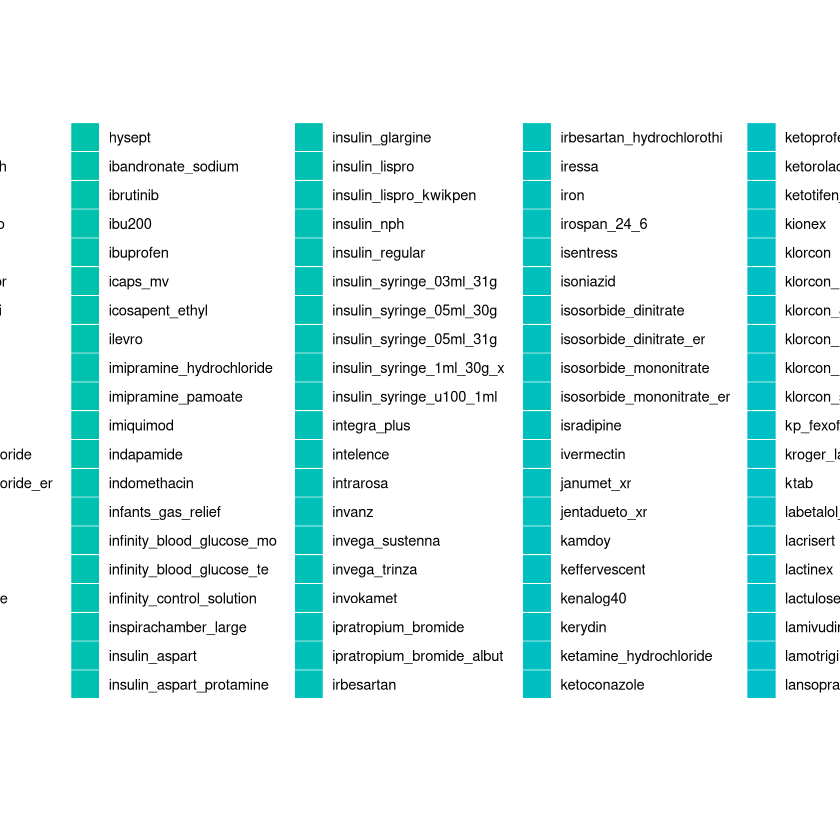

In [13]:
# Quick summary of the event log
summary(target_eventlog)

# Show a few traces (sequences of activities)
trace_explorer(target_eventlog, coverage = 0.8)

# Count of unique activities
activities(target_eventlog)


### Control Cohort

In [14]:

pgx_df_target0_with_drugs <- pgx_df %>%
  filter(target == 0) %>%
  # Remove placeholder or NA drug names
  filter(!is.na(drug_name), drug_name != "", drug_name != "placeholder", drug_name != "ADE_EVENT")


pgx_df_target0_with_drugs %>%
  count(drug_name, sort = TRUE)


drug_name,n
<chr>,<int>
atorvastatin_calcium,6343
amlodipine_besylate,4973
lisinopril,4374
gabapentin,4049
levothyroxine_sodium,3950
furosemide,3736
omeprazole,3406
metformin,3077
losartan_potassium,3075


In [15]:

# Control cohort: target == 0
control_eventlog <- pgx_df_target0_with_drugs %>%
  transmute(
    case_id = mi_person_key,
    timestamp = as.POSIXct(event_date),
    activity = drug_name,
    lifecycle_id = "start"
  ) %>%
  arrange(case_id, timestamp) %>%
  mutate(
    activity_instance_id = row_number(),
    resource_id = "Patient"
  ) %>%
  eventlog(
    case_id = "case_id",
    activity_id = "activity",
    timestamp = "timestamp",
    lifecycle_id = "lifecycle_id",
    activity_instance_id = "activity_instance_id",
    resource_id = "resource_id"
  )


In [16]:
summary(control_eventlog)

Number of events:  206652
Number of cases:  3505
Number of traces:  3492
Number of distinct activities:  1894
Average trace length:  58.9592

Start eventlog:  2016-01-01
End eventlog:  2020-12-31



   case_id            timestamp                       activity        
 Length:206652      Min.   :2016-01-01 00:00:00.0   Length:206652     
 Class :character   1st Qu.:2017-07-06 00:00:00.0   Class :character  
 Mode  :character   Median :2018-07-13 00:00:00.0   Mode  :character  
                    Mean   :2018-07-18 07:10:07.7                     
                    3rd Qu.:2019-08-21 00:00:00.0                     
                    Max.   :2020-12-31 00:00:00.0                     
 lifecycle_id       activity_instance_id resource_id            .order      
 Length:206652      Min.   :     1       Length:206652      Min.   :     1  
 Class :character   1st Qu.: 51664       Class :character   1st Qu.: 51664  
 Mode  :character   Median :103326       Mode  :character   Median :103326  
                    Mean   :103326                          Mean   :103326  
                    3rd Qu.:154989                          3rd Qu.:154989  
                    Max.   :206652       

## 3. Drug Sequences

In [17]:

ade_cases <- target_eventlog %>%
  filter(activity == "ADE_EVENT") %>%
  pull(case_id) %>%
  unique()

log_with_ade <- target_eventlog %>%
  filter(case_id %in% ade_cases)

log_with_ade %>%
  trace_list() %>%
  count(trace, sort = TRUE)


trace,n
<chr>,<int>
ADE_EVENT,1
"ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT",1
"ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT,ADE_EVENT",1


In [18]:
library(dplyr)
library(purrr)
library(lubridate)
library(tidyr)
library(bupaR)

# Prepare base event data
drug_event_df <- pgx_df_target1_with_drugs %>%
  transmute(
    case_id = mi_person_key,
    timestamp = as.POSIXct(event_date),
    activity = drug_name,
    lifecycle_id = "start"
  )

# Keep only events before ADE_EVENT per patient
ade_dates <- drug_event_df %>%
  filter(activity == "ADE_EVENT") %>%
  group_by(case_id) %>%
  summarise(ade_time = min(timestamp), .groups = "drop")

drug_event_df_pre_ade <- drug_event_df %>%
  filter(activity != "ADE_EVENT") %>%
  inner_join(ade_dates, by = "case_id") %>%
  filter(timestamp <= ade_time)

# Get sequential drug windows (within 30 days)
filtered_sequences1 <- drug_event_df_pre_ade %>%
  arrange(case_id, timestamp) %>%
  group_by(case_id) %>%
  summarise(seq = list(activity),
            time = list(timestamp),
            .groups = "drop") %>%
  mutate(filtered_seq = map2(seq, time, function(act, ts) {
    if (length(act) < 2) return(list())
    keep_seq <- list()
    cur_seq <- list(act[1])
    for (i in 2:length(act)) {
      if (as.numeric(difftime(ts[i], ts[i - 1], units = "days")) <= 30) {
        cur_seq <- append(cur_seq, act[i])
      } else {
        if (length(cur_seq) > 1) keep_seq <- append(keep_seq, list(cur_seq))
        cur_seq <- list(act[i])
      }
    }
    if (length(cur_seq) > 1) keep_seq <- append(keep_seq, list(cur_seq))
    keep_seq
  })) %>%
  unnest(filtered_seq) %>%
  mutate(drug_sequence = map_chr(filtered_seq, ~ paste(.x, collapse = " > "))) %>%
  count(drug_sequence, sort = TRUE)

# Step 3: Output top sequential patterns
print(filtered_sequences1, n = 25)



Attaching package: ‘tidyr’


The following object is masked from ‘package:processcheckR’:

    contains




# A tibble: 4,628 × 2
   drug_sequence                                             n
   <chr>                                                 <int>
 1 losartan_potassium > losartan_potassium                  12
 2 lisinopril > lisinopril                                  11
 3 prednisone > prednisone                                   9
 4 hydrocodone_bitartrate_ac > hydrocodone_bitartrate_ac     7
 5 amlodipine_besylate > amlodipine_besylate                 6
 6 simvastatin > simvastatin                                 6
 7 albuterol > albuterol                                     5
 8 atorvastatin_calcium > atorvastatin_calcium               5
 9 ciprofloxacin > ciprofloxacin                             5
10 gabapentin > gabapentin                                   5
11 levofloxacin > levofloxacin                               5
12 amlodipine_besylate > fenofibrate                         4
13 atorvastatin_calcium > metoprolol_er                      4
14 cephalexin > cephalexin       

## 4. Sequences Associated with Hospitalizations

In [20]:
library(dplyr)
library(purrr)
library(lubridate)
library(tidyr)
library(bupaR)

# Prepare base event data
drug_event0 <- pgx_df_target0_with_drugs %>%
  transmute(
    case_id = mi_person_key,
    timestamp = as.POSIXct(event_date),
    activity = drug_name,
    lifecycle_id = "start"
  )

# Get sequential drug windows (within 30 days)
filtered_sequences0 <- drug_event0 %>%
  arrange(case_id, timestamp) %>%
  group_by(case_id) %>%
  summarise(
    seq = list(activity),
    time = list(timestamp),
    .groups = "drop"
  ) %>%
  mutate(filtered_seq = map2(seq, time, function(act, ts) {
    if (length(act) < 4) return(list())
    keep_seq <- list()
    cur_seq <- list(act[1])
    for (i in 4:length(act)) {
      if (as.numeric(difftime(ts[i], ts[i - 1], units = "days")) <= 30) {
        cur_seq <- append(cur_seq, act[i])
      } else {
        if (length(cur_seq) > 1) keep_seq <- append(keep_seq, list(cur_seq))
        cur_seq <- list(act[i])
      }
    }
    if (length(cur_seq) > 1) keep_seq <- append(keep_seq, list(cur_seq))
    keep_seq
  })) %>%
  unnest(filtered_seq) %>%
  mutate(drug_sequence = map_chr(filtered_seq, ~ paste(.x, collapse = " > "))) %>%
  count(drug_sequence, sort = TRUE)

# Output top sequential patterns
print(filtered_sequences0, n = 25)


# A tibble: 7,515 × 2
   drug_sequence                                             n
   <chr>                                                 <int>
 1 lisinopril > lisinopril                                  19
 2 atorvastatin_calcium > atorvastatin_calcium              14
 3 losartan_potassium > losartan_potassium                  13
 4 amlodipine_besylate > amlodipine_besylate                11
 5 simvastatin > simvastatin                                11
 6 gabapentin > gabapentin                                   8
 7 metoprolol > metoprolol                                   8
 8 alprazolam > alprazolam                                   6
 9 atenolol > atenolol                                       6
10 atorvastatin_calcium > amlodipine_besylate                6
11 levothyroxine_sodium > levothyroxine_sodium               6
12 lorazepam > lorazepam                                     6
13 pantoprazole > pantoprazole                               6
14 pravastatin > pravastatin     

## 5. Sankey Chart

In [21]:
quiet({
    library(dplyr)
    library(networkD3)
    
    # Limit to top 25 sequences per group
    target_seqs <- filtered_sequences1 %>%
      rename(sequence = drug_sequence, count = n) %>%
      slice_max(count, n = 25) %>%
      mutate(group = "ADE")
    
    control_seqs <- filtered_sequences0 %>%
      rename(sequence = drug_sequence, count = n) %>%
      slice_max(count, n = 25) %>%
      mutate(group = "Control")
    
    combined <- bind_rows(target_seqs, control_seqs)
    
    # Prepare nodes
    all_nodes <- unique(c(combined$sequence, combined$group))
    nodes <- data.frame(name = all_nodes)
    
    # Prepare links
    links <- combined %>%
      mutate(
        source = match(sequence, nodes$name) - 1,
        target = match(group, nodes$name) - 1
      ) %>%
      select(source, target, value = count)
    
    # Sankey diagram
    sankey_plot <- sankeyNetwork(
      Links = links,
      Nodes = nodes,
      Source = "source",
      Target = "target",
      Value = "value",
      NodeID = "name",
      fontSize = 12,
      nodeWidth = 30
    )
})


HTML widgets cannot be represented in plain text (need html)

In [24]:
quiet({
    library(htmlwidgets)
    # Save locally as HTML
    saveWidget(sankey_plot, "sankey_plot.html", selfcontained = TRUE)
})

NULL

In [ ]:
cat(system("aws s3 sync . s3://pgx-repository/pgx-datasets/ --exact-timestamps --exclude '*' --include '*.ipynb' --include '*.qmd' --include '*.py' --include '*[^.].R' --include '*.png' --exclude '*.Rproj.user/*' --exclude '*.Rproj.user' --exclude '*.trunk/*' --exclude '*.trunk' --exclude '*.venv/*' --exclude '*.venv' --exclude '*.venv311/*' --exclude '*.venv311' --exclude '*.venv310/*' --exclude '*.venv310' --exclude '*.ipynb_checkpoints/*' --exclude '*.ipynb_checkpoints'", intern = TRUE), sep = "\n")


In [ ]:
cat(system("aws s3 sync s3://pgx-repository/pgx-datasets/ . --exact-timestamps --exclude '*' --include '*.ipynb' --include '*.qmd' --include '*.py' --include '*[^.].R' --include '*.png' --exclude '*.Rproj.user/*' --exclude '*.Rproj.user' --exclude '*.trunk/*' --exclude '*.trunk' --exclude '*.venv/*' --exclude '*.venv' --exclude '*.venv311/*' --exclude '*.venv311' --exclude '*.venv310/*' --exclude '*.venv310' --exclude '*.ipynb_checkpoints/*' --exclude '*.ipynb_checkpoints'", intern = TRUE), sep = "\n")


# Back to Main Pipeline
[Return to Main Pipeline](../pgx_cohort_pipeline.ipynb)